In [ ]:
#!pip install pydicom

In [ ]:
#!pip install kornia

In [1]:
from pathlib import Path
import pydicom
import tqdm
import os
import re
import pandas as pd
from fastai.medical.imaging import *
from fastai.vision.all import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
from tqdm import tqdm # for getting a progress bar on loops

In [2]:
# training csv data
train_aug = pd.read_csv('train.csv')
train_aug

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


## Train csv info

In [3]:
dicom_image = 'vinbigdata/train/000434271f63a053c4128a0ba6352c7f.dicom'

In [4]:
train = pd.read_csv('train.csv')
train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [5]:
train[['class_id', 'class_name', 'rad_id']].groupby(['class_id', 'class_name']).count().rename(columns={'rad_id': 'Number of records'})

,,Number of records
class_id,class_name,
0,Aortic enlargement,7162
1,Atelectasis,279
2,Calcification,960
3,Cardiomegaly,5427
4,Consolidation,556
5,ILD,1000
6,Infiltration,1247
7,Lung Opacity,2483
8,Nodule/Mass,2580


In [6]:
records = len(train)
unique_images = len(np.unique(train.image_id))

min_records = np.min( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )
mean_records = np.mean( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )
median_records = np.median( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )
max_records = np.max( train[['image_id', 'class_id']].groupby('image_id').count().reset_index().class_id )

print(f'There are {records} records and {unique_images} images as per image_id.')
print(f'The number of records per image is a mean of {mean_records} (median {median_records}) with a minimum of {min_records} and a maximum of {max_records}')

dedup = train[['image_id', 'rad_id']].drop_duplicates()

min_records = np.min( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )
mean_records = np.mean( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )
median_records = np.median( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )
max_records = np.max( dedup[['image_id', 'rad_id']].groupby('image_id').count().reset_index().rad_id )

print(f'The number of radiologists (rad_id) per is exactly 3 (minimum of {min_records} and a maximum of {max_records}).')

There are 67914 records and 15000 images as per image_id.
The number of records per image is a mean of 4.5276 (median 3.0) with a minimum of 3 and a maximum of 57
The number of radiologists (rad_id) per is exactly 3 (minimum of 3 and a maximum of 3).


In [7]:
# record of 1 image with 3 findings
train[train['image_id']=='000434271f63a053c4128a0ba6352c7f']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
689,000434271f63a053c4128a0ba6352c7f,No finding,14,R6,NaN,NaN,NaN,NaN
56742,000434271f63a053c4128a0ba6352c7f,No finding,14,R2,NaN,NaN,NaN,NaN
65515,000434271f63a053c4128a0ba6352c7f,No finding,14,R3,NaN,NaN,NaN,NaN


# DICOM header info

In [8]:
TEST_DCM = Path('train/9a5094b2563a1ef3ff50dc5c7ff71345.dicom')
dcm = TEST_DCM.dcmread()
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9a5094b2563a1ef3ff50dc5c7ff71345
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '061Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2336
(0028, 0011) Columns                             US: 2080
(0028, 0100) Bits Al

/home/ubuntu/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


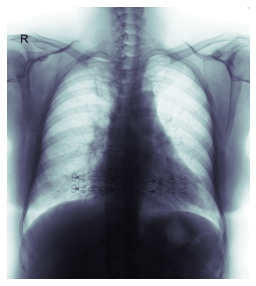

In [9]:
dcm.show();

# Create dataframe with all DICOM header info

In [15]:
f_path = 'train/'
files = [f for f in os.listdir(f_path) if os.path.isfile(os.path.join(f_path, f))]


In [16]:
prog = re.compile('^[A-Z]*')

def get_dcm_contents(file):
    dcm = Path(f_path + file).dcmread()    
    properties = [string for string in dir(dcm) if prog.match(string).group(0)!='']
    dict1 = {'file': file.replace('.dicom', '')}    
    dict1.update( { what: dcm[what].value for what in properties if isinstance(dcm[what].value, (bytes, bytearray))!=True } )
    return dict1
    
# train_files = pd.DataFrame( [ get_dcm_contents(file) for file in tqdm(files) ] )

In [17]:
train_files = pd.DataFrame( [ get_dcm_contents(file) for file in tqdm(files) ] )

100%|██████████| 15000/15000 [12:41<00:00, 19.71it/s]


In [18]:
train_files.head()

,file,BitsAllocated,BitsStored,Columns,HighBit,LossyImageCompression,PatientSex,PhotometricInterpretation,PixelRepresentation,PixelSpacing,...,WindowWidth,PatientSize,PatientWeight,PixelAspectRatio,PatientAge,LossyImageCompressionRatio,LargestImagePixelValue,SmallestImagePixelValue,LossyImageCompressionMethod,NumberOfFrames
0,a1faed880dcdf84e3e3ada546a409311,16,12,1994,11,00,O,MONOCHROME2,0,"[0.175, 0.175]",...,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,986cbf62313a140fc59925d613ed4332,16,12,2304,11,00,F,MONOCHROME1,0,"[0.15, 0.15]",...,4095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7f0d9559e81ae52e9d046609d419dca1,16,12,3000,11,00,F,MONOCHROME2,0,NaN,...,4095.0,0.0,0.0,"[1, 1]",NaN,NaN,NaN,NaN,NaN,NaN
3,3a0d195ad217ba81a6d83c2193c03a39,16,14,2353,13,00,M,MONOCHROME2,0,"[0.14300, 0.14300]",...,16383.0,0.0,0.0,"[1, 1]",039Y,NaN,NaN,NaN,NaN,NaN
4,de148636aedb29a1e610b3a8010a7c42,16,14,2752,13,00,F,MONOCHROME2,0,"[0.127, 0.127]",...,5536.0,NaN,NaN,NaN,032Y,2.0,NaN,NaN,NaN,NaN


In [19]:
f_path = 'test/'
files = [f for f in os.listdir(f_path) if os.path.isfile(os.path.join(f_path, f))]

In [20]:
test_files = pd.DataFrame( [ get_dcm_contents(file) for file in tqdm(files) ] )

100%|██████████| 3000/3000 [02:32<00:00, 19.70it/s]


In [21]:
test_files.head()

,file,BitsAllocated,BitsStored,Columns,HighBit,LossyImageCompression,PatientSex,PhotometricInterpretation,PixelRepresentation,PixelSpacing,...,WindowWidth,NumberOfFrames,PatientAge,PixelAspectRatio,LossyImageCompressionRatio,PatientSize,PatientWeight,LossyImageCompressionMethod,LargestImagePixelValue,SmallestImagePixelValue
0,8b44752d98acbc233b093260c0f2061d,16,12,1994,11,00,O,MONOCHROME2,0,"[0.175, 0.175]",...,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3ca907c03b1409d8a703591f6ca7882e,16,12,2410,11,00,,MONOCHROME2,0,"[0.125, 0.125]",...,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b0634373edac7074e2ab28a088ee0612,16,12,2637,11,00,,MONOCHROME2,0,"[0.125, 0.125]",...,4250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,af814787d788b29059ae3419a3b38dbd,16,16,1746,15,00,M,MONOCHROME2,0,"[0.141, 0.141]",...,58635.0,1.0,000Y,None,NaN,NaN,NaN,NaN,NaN,NaN
4,fe5c2e4756820873cd6e8332ad4c2e12,16,12,2836,11,00,,MONOCHROME2,0,"[0.125, 0.125]",...,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# expand columns
pd.set_option('display.max_columns', 500)

In [23]:
train_files.head()

,file,BitsAllocated,BitsStored,Columns,HighBit,LossyImageCompression,PatientSex,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,Rows,SamplesPerPixel,WindowCenter,WindowWidth,PatientSize,PatientWeight,PixelAspectRatio,PatientAge,LossyImageCompressionRatio,LargestImagePixelValue,SmallestImagePixelValue,LossyImageCompressionMethod,NumberOfFrames
0,a1faed880dcdf84e3e3ada546a409311,16,12,1994,11,00,O,MONOCHROME2,0,"[0.175, 0.175]",0.0,1.0,2430,1,2047.0,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,986cbf62313a140fc59925d613ed4332,16,12,2304,11,00,F,MONOCHROME1,0,"[0.15, 0.15]",0.0,1.0,2880,1,2047.0,4095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7f0d9559e81ae52e9d046609d419dca1,16,12,3000,11,00,F,MONOCHROME2,0,NaN,0.0,1.0,3000,1,2047.0,4095.0,0.0,0.0,"[1, 1]",NaN,NaN,NaN,NaN,NaN,NaN
3,3a0d195ad217ba81a6d83c2193c03a39,16,14,2353,13,00,M,MONOCHROME2,0,"[0.14300, 0.14300]",0.0,1.0,2209,1,8191.0,16383.0,0.0,0.0,"[1, 1]",039Y,NaN,NaN,NaN,NaN,NaN
4,de148636aedb29a1e610b3a8010a7c42,16,14,2752,13,00,F,MONOCHROME2,0,"[0.127, 0.127]",0.0,1.0,2832,1,8266.0,5536.0,NaN,NaN,NaN,032Y,2.0,NaN,NaN,NaN,NaN


In [24]:
# columns = ['file',
#            'BitsAllocated',
#            'BitsStored',
#            'Columns',
#            'HighBit',
#            'LossyImageCompression',
#            'PatientSex',
#            'PhotometricInterpretation',
#            'PixelRepresentation',
#            'PixelSpacing',
#            'RescaleIntercept',
#            'RescaleSlope',
#            'Rows',
#            'SamplesPerPixel',
#            'WindowCenter',
#            'WindowWidth',
#            'PatientSize',
#            'PatientWeight',
#            'PixelAspectRatio',
#            'PatientAge',
#            'LossyImageCompressionRatio',
#            'LargestImagePixelValue',
#            'SmallestImagePixelValue',
#            'LossyImageCompressionMethod',
#            'NumberOfFrames']
           
           

In [26]:
df = train_files.append(test_files, ignore_index=True)
df

,file,BitsAllocated,BitsStored,Columns,HighBit,LossyImageCompression,PatientSex,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,Rows,SamplesPerPixel,WindowCenter,WindowWidth,PatientSize,PatientWeight,PixelAspectRatio,PatientAge,LossyImageCompressionRatio,LargestImagePixelValue,SmallestImagePixelValue,LossyImageCompressionMethod,NumberOfFrames
0,a1faed880dcdf84e3e3ada546a409311,16,12,1994,11,00,O,MONOCHROME2,0,"[0.175, 0.175]",0.0,1.0,2430,1,2047.0,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,986cbf62313a140fc59925d613ed4332,16,12,2304,11,00,F,MONOCHROME1,0,"[0.15, 0.15]",0.0,1.0,2880,1,2047.0,4095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7f0d9559e81ae52e9d046609d419dca1,16,12,3000,11,00,F,MONOCHROME2,0,NaN,0.0,1.0,3000,1,2047.0,4095.0,0.0,0.0,"[1, 1]",NaN,NaN,NaN,NaN,NaN,NaN
3,3a0d195ad217ba81a6d83c2193c03a39,16,14,2353,13,00,M,MONOCHROME2,0,"[0.14300, 0.14300]",0.0,1.0,2209,1,8191.0,16383.0,0.0,0.0,"[1, 1]",039Y,NaN,NaN,NaN,NaN,NaN
4,de148636aedb29a1e610b3a8010a7c42,16,14,2752,13,00,F,MONOCHROME2,0,"[0.127, 0.127]",0.0,1.0,2832,1,8266.0,5536.0,NaN,NaN,NaN,032Y,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,e33d9cf93e5e673950f7448dc79de500,16,12,2048,11,00,O,MONOCHROME2,0,"[0.168, 0.168]",0.0,1.0,2500,1,2048.0,4096.0,NaN,NaN,"[1, 1]",NaN,NaN,4095.0,0.0,NaN,NaN
17996,6facd092dfec22384fd9446fd84c1ce3,16,12,2923,11,00,,MONOCHROME2,0,"[0.125, 0.125]",0.0,1.0,2913,1,1010.0,4918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,b7c7ddcf253b397213116453bb085158,16,12,2770,11,00,,MONOCHROME2,0,"[0.125, 0.125]",0.0,1.0,3138,1,1058.0,5160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,f592ac6b878d2b7929e3723347f2cfd4,16,16,2000,15,00,M,MONOCHROME2,0,"[0.141, 0.141]",NaN,NaN,2498,1,31058.0,62268.0,NaN,NaN,None,000Y,NaN,NaN,NaN,NaN,1.0


In [33]:
# all files are unique
df['file'].nunique()

18000

# Columns that need to be added that are not in the DICOM header info

In [ ]:
# image_id,
# class_id,
# rad_id,
# x_min,
# y_min,
# x_max,
# y_max,
# width,
# height,
# image_path,
# class_name,
# x_mid,
# y_mid,
# w,
# h,
# area,
# PredictionString

In [36]:
!pip install pandas-profiling

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 261 kB 25.7 MB/s            
     |████████████████████████████████| 675 kB 67.4 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.1 MB 67.7 MB/s            
     |████████████████████████████████| 102 kB 21.6 MB/s           
     |████████████████████████████████| 812 kB 73.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=9f7bef7931a3dcc7826b1187277bdd79f6a0ed94a456b2cf137212dceb622e6c
  Stored in directory: /home/ubuntu/.cache/pip/wheels/70/e1/52/5b14d250ba8687

In [37]:
import pandas_profiling

In [38]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Save as csv 

In [30]:
# This is so David can continue modeling work in a seperate notebook 
# df.to_csv('all_dicom_headers.csv', index=False)

# Plug in to SingleStore

In [28]:
# The dataframe df needs to be pushed to SingleStore


In [34]:
# !pwd

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/home/ubuntu/vinbigdata


In [39]:
df

,file,BitsAllocated,BitsStored,Columns,HighBit,LossyImageCompression,PatientSex,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,Rows,SamplesPerPixel,WindowCenter,WindowWidth,PatientSize,PatientWeight,PixelAspectRatio,PatientAge,LossyImageCompressionRatio,LargestImagePixelValue,SmallestImagePixelValue,LossyImageCompressionMethod,NumberOfFrames
0,a1faed880dcdf84e3e3ada546a409311,16,12,1994,11,00,O,MONOCHROME2,0,"[0.175, 0.175]",0.0,1.0,2430,1,2047.0,4096.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,986cbf62313a140fc59925d613ed4332,16,12,2304,11,00,F,MONOCHROME1,0,"[0.15, 0.15]",0.0,1.0,2880,1,2047.0,4095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7f0d9559e81ae52e9d046609d419dca1,16,12,3000,11,00,F,MONOCHROME2,0,NaN,0.0,1.0,3000,1,2047.0,4095.0,0.0,0.0,"[1, 1]",NaN,NaN,NaN,NaN,NaN,NaN
3,3a0d195ad217ba81a6d83c2193c03a39,16,14,2353,13,00,M,MONOCHROME2,0,"[0.14300, 0.14300]",0.0,1.0,2209,1,8191.0,16383.0,0.0,0.0,"[1, 1]",039Y,NaN,NaN,NaN,NaN,NaN
4,de148636aedb29a1e610b3a8010a7c42,16,14,2752,13,00,F,MONOCHROME2,0,"[0.127, 0.127]",0.0,1.0,2832,1,8266.0,5536.0,NaN,NaN,NaN,032Y,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,e33d9cf93e5e673950f7448dc79de500,16,12,2048,11,00,O,MONOCHROME2,0,"[0.168, 0.168]",0.0,1.0,2500,1,2048.0,4096.0,NaN,NaN,"[1, 1]",NaN,NaN,4095.0,0.0,NaN,NaN
17996,6facd092dfec22384fd9446fd84c1ce3,16,12,2923,11,00,,MONOCHROME2,0,"[0.125, 0.125]",0.0,1.0,2913,1,1010.0,4918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,b7c7ddcf253b397213116453bb085158,16,12,2770,11,00,,MONOCHROME2,0,"[0.125, 0.125]",0.0,1.0,3138,1,1058.0,5160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,f592ac6b878d2b7929e3723347f2cfd4,16,16,2000,15,00,M,MONOCHROME2,0,"[0.141, 0.141]",NaN,NaN,2498,1,31058.0,62268.0,NaN,NaN,None,000Y,NaN,NaN,NaN,NaN,1.0


In [ ]:
type